In [2]:
from plot_ult import *

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


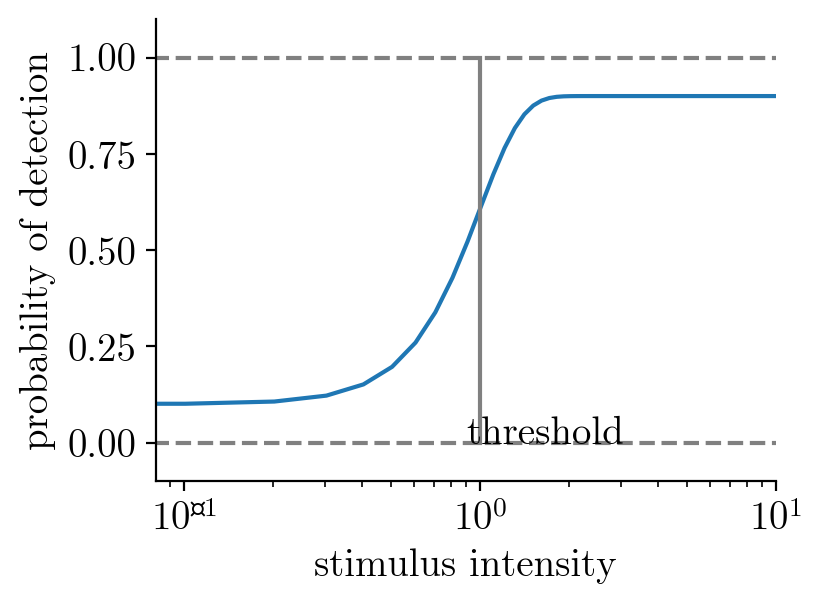

In [3]:

# the psi function. P(x) = γ + (1 - γ - λ) * exp[-(x/α)^β]
class Psychometric:
    def __init__(self, gamma, lamda, threshold, slope) -> None:
        self.gamma=gamma # false alarm
        self.lamda=lamda # lapse
        self.threshold=threshold # threshold
        self.slope=slope # slope
    def __call__(self, x):
        return 1- (self.gamma + (1 - self.gamma - self.lamda) * np.exp(-(x/self.threshold)**self.slope))
    def plot(self, therange=[0,10],n=100):
        xs=np.linspace(therange[0], therange[1], n)
        with initiate_plot(4,3,200) as f:
            ax=f.add_subplot(111)
            plt.xscale('log')
            plt.plot(xs, policy(xs))
            plt.xlabel('stimulus intensity')
            plt.ylabel('probability of detection')
            plt.ylim(-0.1,1.1)
            plt.xlim(therange[0], therange[1])
            plt.plot(xs, np.zeros_like(xs), '--', color='grey')
            plt.plot(xs, np.ones_like(xs), '--', color='grey')
            plt.plot([self.threshold,self.threshold],[0,1], '-', color='grey')
            plt.text(self.threshold-0.1,0,'threshold')
            quickspine(ax)

        plt.show()

param={
    'gamma':.1, 
    'lamda':.1, 
    'threshold':1, 
    'slope':3
}
policy=Psychometric(**param)
policy.plot(therange=[0,10])

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

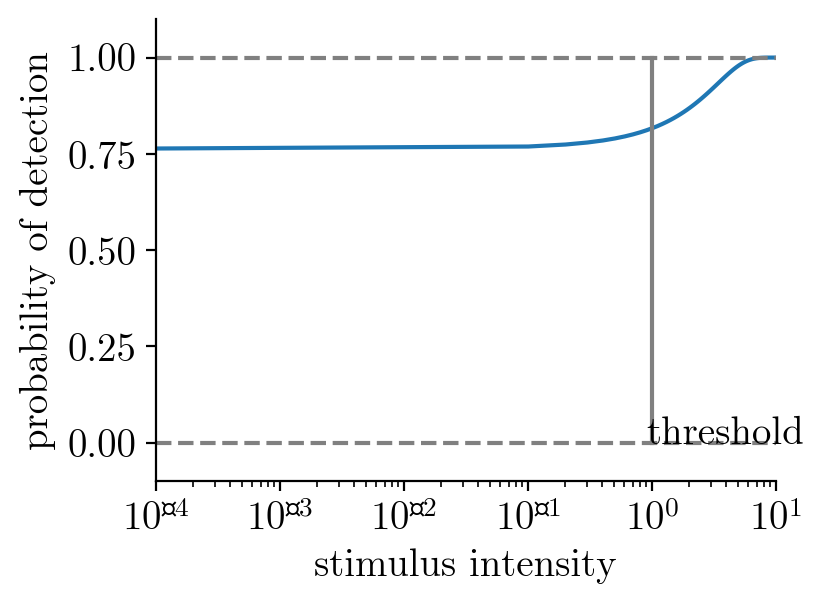

In [4]:





class PsychometricF2C:
    def __init__(self, gamma, lamda, threshold, slope) -> None:
        self.gamma=gamma # false alarm
        self.lamda=lamda # lapse
        self.threshold=threshold # threshold
        self.slope=slope # slope
    def __call__(self, x,e=0):
        return 1-(1-self.gamma)*np.exp(-10**(self.slope/20*(x-self.threshold+e)))
    def plot(self, therange=[0,10],n=100):
        xs=np.linspace(therange[0], therange[1], n)
        with initiate_plot(4,3,200) as f:
            ax=f.add_subplot(111)
            plt.xscale('log')
            plt.plot(xs, policy(xs))
            plt.xlabel('stimulus intensity')
            plt.ylabel('probability of detection')
            plt.ylim(-0.1,1.1)
            plt.xlim(therange[0], therange[1])
            plt.plot(xs, np.zeros_like(xs), '--', color='grey')
            plt.plot(xs, np.ones_like(xs), '--', color='grey')
            plt.plot([self.threshold,self.threshold],[0,1], '-', color='grey')
            plt.text(self.threshold-0.1,0,'threshold')
            quickspine(ax)
        plt.show()

param={
    'gamma':0.5,  # success at 0 intensity
    'lamda':.1, 
    'threshold':1, 
    'slope':2.5
}
policy=PsychometricF2C(**param)
policy.plot(therange=[10**-4,10])


0.0065261509554911095

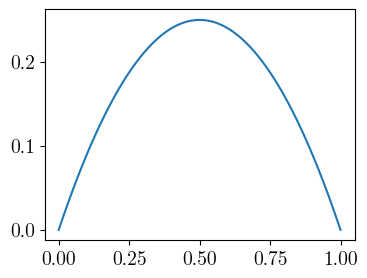

In [ ]:
# placement rule
xs=np.linspace(0,1, 100)
def fun(x):
    return x*(1-x)
plt.plot(xs,fun(xs))

# for one trial (stimulus), calculate the prob of success
phi=0.5
p=policy(phi)
p # success
1-p # failure

# for n trials, calculate the likelihood p(data|threshold)
data=[0,0,1,0,1]
phi_ls=[0.1,0.3,0.5,0.7,0.9]
Q=0
for r,phi in zip(data,phi_ls):
    p=policy(phi)
    if r: # success
        Q+=np.log(p)
    else:
        Q+=np.log(1-p)
np.exp(Q)


--- Running QUEST Simulation ---

--- Plotting Results ---


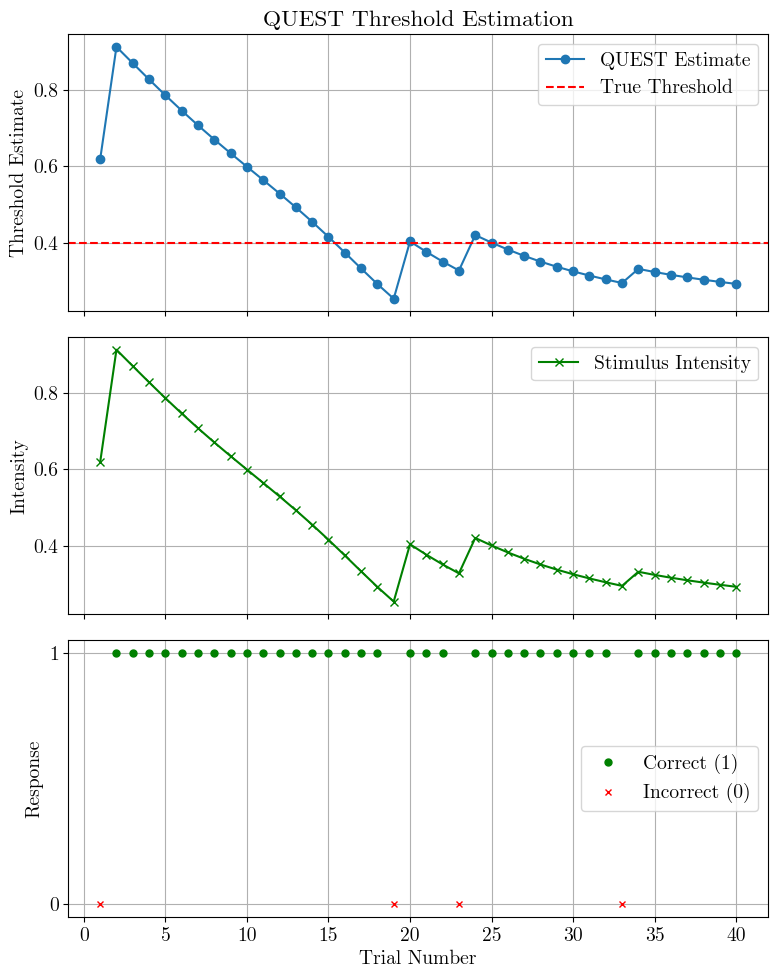

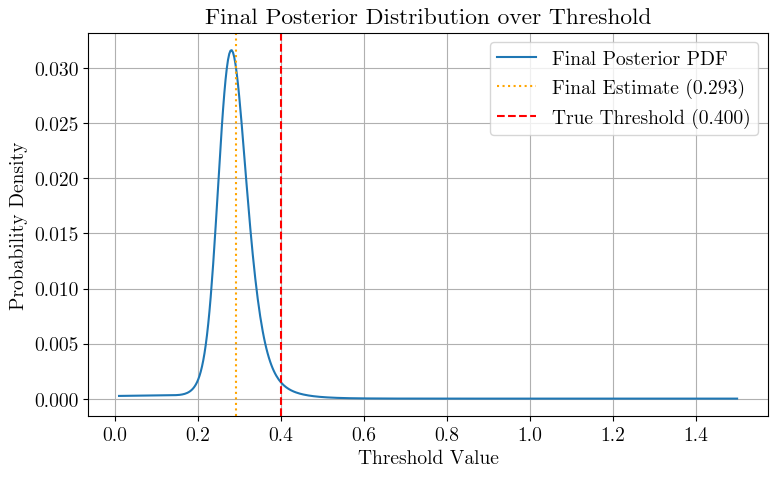

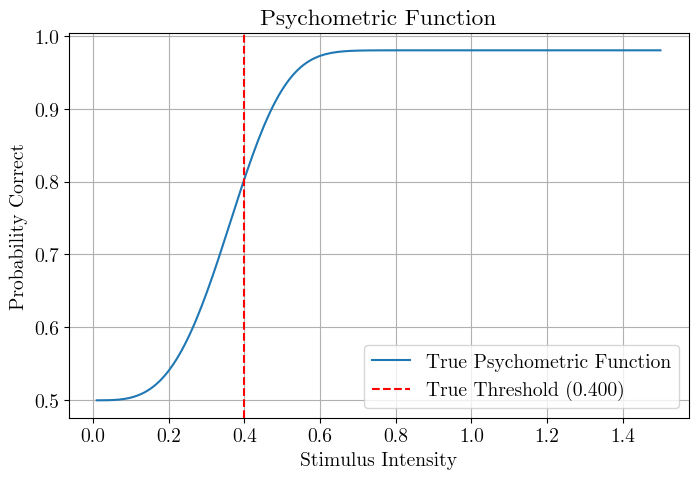

In [7]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def weibull_psychometric(intensity, threshold, beta, gamma, lapse_rate):
    """
    Calculates the probability of a correct response using the Weibull function.

    P(correct) = gamma + (1 - gamma - lapse_rate) * (1 - exp(-(intensity/threshold)**beta))

    Note: The original probe_function had a slightly different form.
          This uses a more standard Weibull CDF formulation adjusted for guess/lapse.
          Ensure this matches your intended psychometric function.
          If intensity can be zero or negative, this function might need adjustments.
          We clamp intensity to a small positive value to avoid issues with 0^beta.
    """
    intensity = np.maximum(intensity, 1e-9) # Avoid intensity <= 0
    prob_detect = 1.0 - np.exp(-(intensity / threshold)**beta)
    p_correct = gamma + (1.0 - gamma - lapse_rate) * prob_detect
    # Clamp probability between gamma and 1-lapse_rate
    return np.clip(p_correct, gamma, 1.0 - lapse_rate)

def quest(
    probe_function, # Function defining P(correct | intensity, threshold)
    initial_threshold_estimate, # Where the prior is centered
    prior_std, # Std dev of Gaussian prior
    beta, # Slope parameter (used by probe_function)
    gamma, # Guess rate (used by probe_function)
    lapse_rate, # Lapse rate (used by probe_function)
    num_trials,
    threshold_range, # Tuple (min_threshold, max_threshold)
    threshold_resolution=500 # Number of points in threshold grid
    ):
    """
    Implements the QUEST procedure using Bayesian updates on a threshold grid.

    Parameters:
    probe_function (function): Psychometric function P(correct | intensity, threshold, beta, gamma, lapse_rate).
                               Must accept intensity and threshold as arguments.
    initial_threshold_estimate (float): The mean of the prior distribution on the threshold.
    prior_std (float): The standard deviation of the prior distribution.
    beta (float): Slope parameter for the psychometric function.
    gamma (float): Guessing rate for the psychometric function.
    lapse_rate (float): Lapse rate for the psychometric function.
    num_trials (int): The number of trials to run.
    threshold_range (tuple): Min and max possible threshold values to consider.
    threshold_resolution (int): Number of points for the threshold grid.

    Returns:
    threshold_estimates (ndarray): Estimated threshold (posterior mean) at each trial.
    intensities (ndarray): Stimulus intensities used at each trial.
    responses (ndarray): Observer's responses (0 or 1) at each trial.
    final_posterior_pdf (ndarray): The final posterior probability distribution over thresholds.
    threshold_grid (ndarray): The grid of threshold values used.
    """
    # --- Setup ---
    threshold_min, threshold_max = threshold_range
    # Create a grid of possible threshold values
    threshold_grid = np.linspace(threshold_min, threshold_max, threshold_resolution)
    # Ensure threshold grid values are positive for Weibull function
    threshold_grid = np.maximum(threshold_grid, 1e-9)

    # Initialize prior PDF (Gaussian) - work in log space for stability
    # Use log-normal if thresholds must be positive, or truncated normal.
    # Here, using Gaussian on the linear threshold grid for simplicity as in original code.
    prior_pdf = norm.pdf(threshold_grid, loc=initial_threshold_estimate, scale=prior_std)
    # Handle cases where prior_std is very small or range is large
    if np.sum(prior_pdf) < 1e-9:
         print("Warning: Prior PDF sums to near zero. Check prior_std and threshold_range. Setting uniform prior.")
         prior_pdf = np.ones_like(threshold_grid) # Fallback to uniform

    # Normalize the prior PDF
    prior_pdf /= np.sum(prior_pdf)
    posterior_pdf = prior_pdf.copy()

    # Store results
    threshold_estimates = np.zeros(num_trials)
    intensities = np.zeros(num_trials)
    responses = np.zeros(num_trials) # Store actual 0/1 responses

    # --- QUEST Loop ---
    for i in range(num_trials):
        # 1. Estimate current threshold (e.g., mean of posterior)
        # Expected value of the threshold given the posterior PDF
        current_threshold_estimate = np.sum(posterior_pdf * threshold_grid)
        threshold_estimates[i] = current_threshold_estimate

        # 2. Choose stimulus intensity for this trial
        # Simplification: Use the current threshold estimate as the intensity.
        # Standard QUEST often chooses intensity to maximize expected information gain,
        # which is more complex to implement. Using the mean is common.
        intensity = current_threshold_estimate
        # Ensure intensity is within a reasonable range if needed, e.g., prevent negative values
        intensity = max(intensity, 1e-9) # Prevent negative/zero intensity for Weibull
        intensities[i] = intensity

        # 3. Get observer's response (Simulate using the true function)
        # In a real experiment, this comes from the participant.
        # Here, we simulate it using the *true* underlying threshold (if known)
        # or using the probe_function with the *current estimate* if true is unknown.
        # Let's assume we have a way to get the response probability for the *chosen* intensity.
        # ** IMPORTANT: In your original code, you called probe_function(intensity)
        # which implicitly used the 'true_threshold' defined outside. We need that here too
        # for simulation, or pass it explicitly. Let's assume 'true_threshold' exists globally for simulation.**
        try:
             p_correct_true = weibull_psychometric(intensity, true_threshold, beta, gamma, lapse_rate)
        except NameError:
             print("Warning: 'true_threshold' not defined globally for simulation. Simulating based on current estimate.")
             # If true_threshold isn't known, the best guess is the current estimate
             p_correct_true = weibull_psychometric(intensity, current_threshold_estimate, beta, gamma, lapse_rate)

        response = np.random.binomial(1, p_correct_true) # Simulate 0 or 1
        responses[i] = response

        # 4. Calculate Likelihood P(response | intensity, threshold_k) for each possible threshold
        # Probability of getting the observed response (0 or 1) given the stimulus intensity,
        # for each threshold value on our grid.
        p_correct_hypothetical = weibull_psychometric(intensity, threshold_grid, beta, gamma, lapse_rate)

        if response == 1: # Correct response
            likelihood = p_correct_hypothetical
        else: # Incorrect response
            likelihood = 1.0 - p_correct_hypothetical

        # 5. Update Posterior PDF
        # Posterior = Prior * Likelihood (or LogPosterior = LogPrior + LogLikelihood)
        # Handle potential zero likelihoods to avoid issues
        likelihood = np.maximum(likelihood, 1e-9) # Floor likelihood
        posterior_pdf = posterior_pdf * likelihood

        # 6. Normalize Posterior PDF
        posterior_sum = np.sum(posterior_pdf)
        if posterior_sum < 1e-9:
             print(f"Warning: Posterior sum is near zero at trial {i+1}. Re-normalizing might fail. Resetting to uniform.")
             # Reset to uniform if posterior collapses (e.g., due to extreme likelihoods)
             posterior_pdf = np.ones_like(threshold_grid) / len(threshold_grid)
        else:
            posterior_pdf /= posterior_sum

        # Optional: Print progress (can be removed)
        # print(f"Trial {i+1}: Intensity={intensity:.3f}, Response={response}, Est. Threshold={current_threshold_estimate:.3f}")


    return threshold_estimates, intensities, responses, posterior_pdf, threshold_grid


# =============================================================================
# Simulation Setup (Similar to your original code)
# =============================================================================

# --- Parameters ---
initial_threshold_estimate = 0.5 # Starting guess for QUEST prior mean
prior_std = 0.5             # Standard deviation of prior (wider than before)
beta = 3.5                  # Slope
gamma = 0.5                 # Guess rate (e.g., 0.5 for 2AFC)
lapse_rate = 0.02           # Lapse rate
num_trials = 40             # More trials for convergence
true_threshold = 0.4        # The actual threshold for simulation

# Define the range of thresholds QUEST should consider
# Should comfortably contain the true_threshold and initial estimate
threshold_range = (0.01, 1.5) # Min and Max threshold values

# --- Run QUEST ---
print("--- Running QUEST Simulation ---")
threshold_estimates, intensities, responses, final_posterior_pdf, threshold_grid = quest(
    weibull_psychometric, # Pass the psychometric function
    initial_threshold_estimate,
    prior_std,
    beta,
    gamma,
    lapse_rate,
    num_trials,
    threshold_range
)

# =============================================================================
# Plotting Results
# =============================================================================
print("\n--- Plotting Results ---")

fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# Plot 1: Threshold Estimate Convergence
axes[0].plot(np.arange(1, num_trials + 1), threshold_estimates, marker='o', linestyle='-', label='QUEST Estimate')
axes[0].axhline(true_threshold, color='r', linestyle='--', label='True Threshold')
axes[0].set_ylabel('Threshold Estimate')
axes[0].set_title('QUEST Threshold Estimation')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Stimulus Intensities Presented
axes[1].plot(np.arange(1, num_trials + 1), intensities, marker='x', linestyle='-', color='g', label='Stimulus Intensity')
axes[1].set_ylabel('Intensity')
axes[1].grid(True)
axes[1].legend()

# Plot 3: Responses
# Map 0/1 responses to markers for clarity
correct_trials = np.where(responses == 1)[0]
incorrect_trials = np.where(responses == 0)[0]
axes[2].plot(correct_trials + 1, responses[correct_trials], 'go', markersize=5, label='Correct (1)')
axes[2].plot(incorrect_trials + 1, responses[incorrect_trials], 'rx', markersize=5, label='Incorrect (0)')
axes[2].set_yticks([0, 1])
axes[2].set_ylabel('Response')
axes[2].set_xlabel('Trial Number')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()


# Plot Final Posterior PDF
fig_pdf, ax_pdf = plt.subplots(figsize=(8, 5))
ax_pdf.plot(threshold_grid, final_posterior_pdf, label='Final Posterior PDF')
ax_pdf.axvline(threshold_estimates[-1], color='orange', linestyle=':', label=f'Final Estimate ({threshold_estimates[-1]:.3f})')
ax_pdf.axvline(true_threshold, color='r', linestyle='--', label=f'True Threshold ({true_threshold:.3f})')
ax_pdf.set_xlabel('Threshold Value')
ax_pdf.set_ylabel('Probability Density')
ax_pdf.set_title('Final Posterior Distribution over Threshold')
ax_pdf.legend()
ax_pdf.grid(True)
plt.tight_layout()


# Plot Psychometric Function (Example)
fig_psy, ax_psy = plt.subplots(figsize=(8, 5))
xs_plot = np.linspace(threshold_range[0], threshold_range[1], 200)
ys_plot = weibull_psychometric(xs_plot, true_threshold, beta, gamma, lapse_rate)
ax_psy.plot(xs_plot, ys_plot, label='True Psychometric Function')
# Plot simulated points (optional, can be noisy)
# ax_psy.scatter(intensities, responses, c=responses, cmap='coolwarm', marker='o', label='Simulated Trials', alpha=0.6, zorder=5)
ax_psy.axvline(true_threshold, color='r', linestyle='--', label=f'True Threshold ({true_threshold:.3f})')
ax_psy.set_xlabel('Stimulus Intensity')
ax_psy.set_ylabel('Probability Correct')
ax_psy.set_title('Psychometric Function')
ax_psy.legend()
ax_psy.grid(True)

plt.show()

# Your original plotting code (unrelated to QUEST function fix)
# xs=np.linspace(0.,1,50)
# ys=xs*(1-xs) # This is just a parabola, not related to Weibull

# weibull PDF plot
# xs_pdf=np.linspace(0,5,50) # Start slightly > 0 if using formula directly
# threshold_pdf=3;slope_pdf=3.5
# weibull_pdf = (slope_pdf/threshold_pdf)*(xs_pdf/threshold_pdf)**(slope_pdf-1)*np.exp(-((xs_pdf)/threshold_pdf)**slope_pdf)
# plt.figure()
# plt.plot(xs_pdf,weibull_pdf, label='Weibull PDF Example')
# plt.title("Weibull PDF Example")
# plt.xlabel("x")
# plt.ylabel("Probability Density")
# plt.grid(True)
# plt.show()


# derivative of weibull (commented out)
# t=threshold;k=slope;x=xs
# d=-(np.exp(-(x/t)**k) *k* (x/t)**k *(-1 + k*(-1 + (x/t)**k)))/t**2


# cdf, psychometric function plot (already plotted above)
# xs_cdf=np.linspace(0,5,50)
# threshold_cdf=2;slope_cdf=3.5;chancelevel_cdf=0.5
# weibullcdf=1-(1-chancelevel_cdf)*np.exp(-((xs_cdf)/threshold_cdf)**slope_cdf) # This is another form of Weibull CDF
# plt.figure()
# plt.plot(xs_cdf,weibullcdf,label='Psychometric Function Example (Alternative Form)')
# plt.title("Psychometric Function Example")
# plt.xlabel("Stimulus Intensity")
# plt.ylabel("Probability Correct")
# plt.grid(True)
# plt.show()



--- Calculating Psychometric Function and Derivatives vs. Threshold ---
--- Plotting: Linear Scale ---


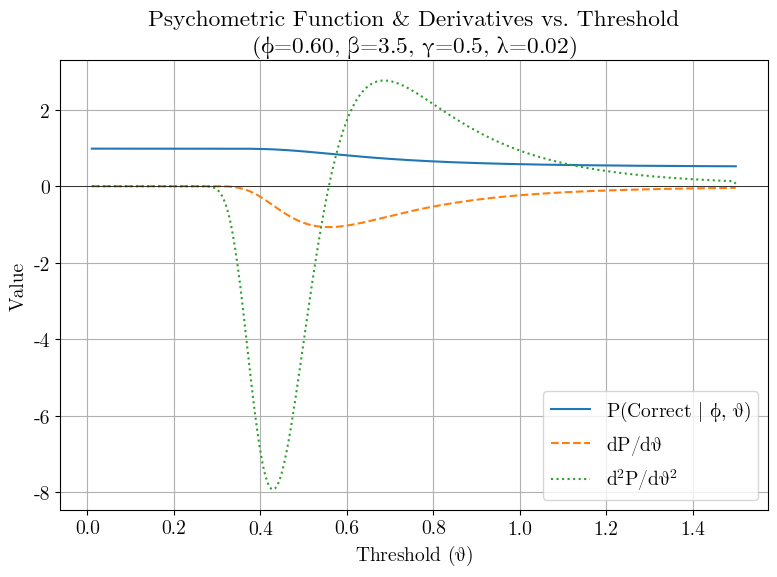


--- Calculating Log Psychometric Function and Derivatives vs. Threshold ---
--- Plotting: Log Scale ---


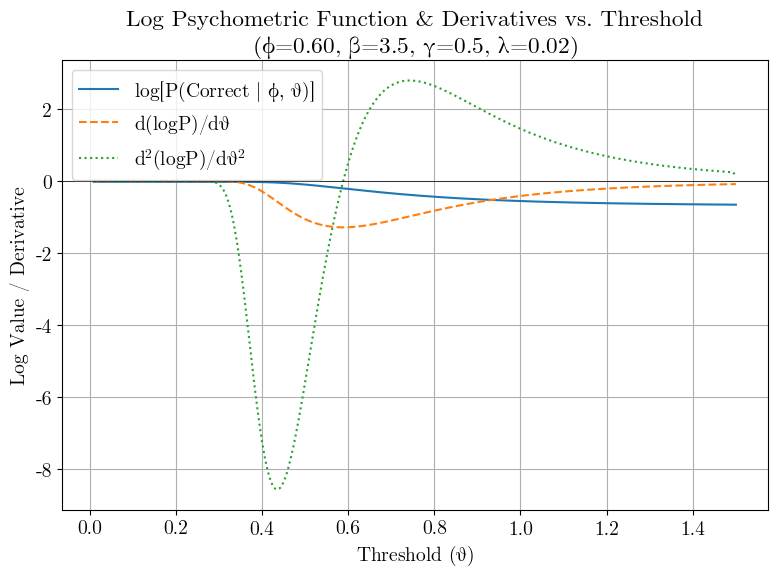


--- Calculating and Plotting Fisher Information Term vs. Threshold ---
--- Plotting: Fisher Information Term ---


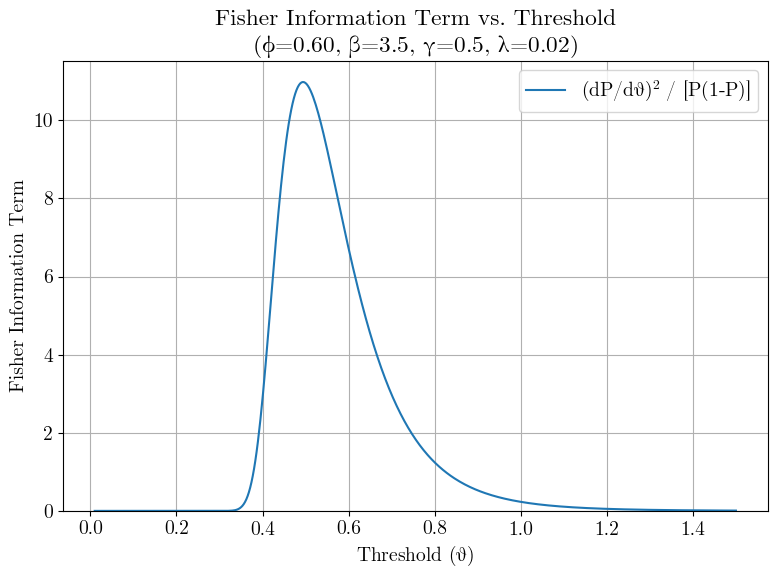


--- Plotting Entropy Term vs. Threshold ---


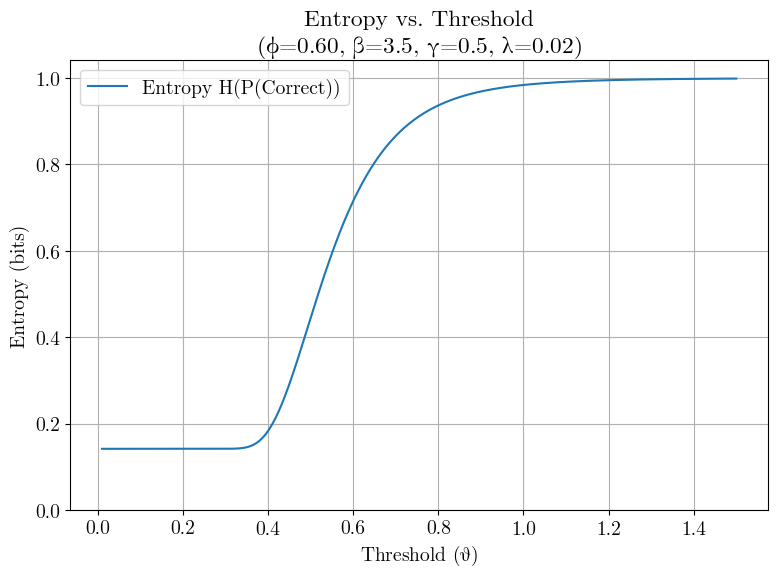


--- Plotting P*(1-P) vs. Threshold ---


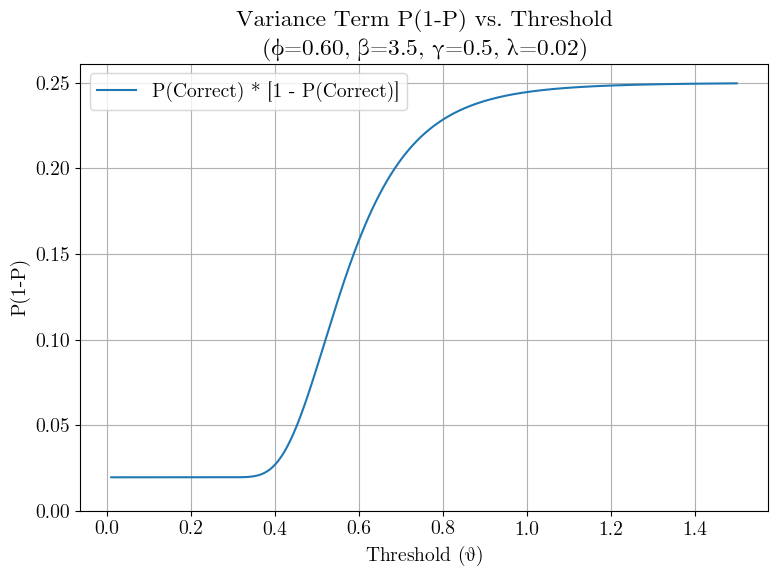


Code execution complete.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm # Keep for potential future use, not strictly needed here

# =============================================================================
# Parameters (Based on previous QUEST simulation setup)
# =============================================================================
# Define parameters for the psychometric function.
# Ensure these match the context you intend (e.g., from quest_fix_py)
beta = 3.5                  # Slope parameter
gamma = 0.5                 # Guess rate (e.g., 0.5 for 2AFC)
lapse_rate = 0.02           # Lapse rate
delta = 1.0 - lapse_rate    # Often used in QUEST literature (1 - lapse_rate)

# Define a fixed stimulus intensity (phi in your original code)
# This is the intensity presented to the observer.
stimulus_intensity_phi = 0.6 # Example fixed intensity (must be > 0)

# Define a range for the threshold parameter (theta or t in your original code)
# This is the variable we will plot against. Threshold must be > 0.
theta_min = 0.01
theta_max = 1.5
theta_resolution = 500
theta_range = np.linspace(theta_min, theta_max, theta_resolution)

# =============================================================================
# Psychometric Function Definition (Consistent with quest_fix_py)
# =============================================================================

def weibull_psychometric(intensity, threshold, beta, gamma, lapse_rate):
    """
    Calculates the probability of a correct response using the Weibull function.
    P(correct) = gamma + (1 - gamma - lapse_rate) * (1 - exp(-(intensity/threshold)**beta))
    """
    # Ensure inputs are positive as required by the function
    intensity = np.maximum(intensity, 1e-9)
    threshold = np.maximum(threshold, 1e-9) # Threshold must be positive
    prob_detect = 1.0 - np.exp(-(intensity / threshold)**beta)
    p_correct = gamma + (1.0 - gamma - lapse_rate) * prob_detect
    # Clamp probability between gamma and 1-lapse_rate (physical limits)
    return np.clip(p_correct, gamma, 1.0 - lapse_rate)

# =============================================================================
# Calculate Psychometric Function and Derivatives vs. Threshold (theta)
# =============================================================================
print("--- Calculating Psychometric Function and Derivatives vs. Threshold ---")

# Calculate P(correct) for the fixed stimulus intensity across the range of thresholds
p_correct_vs_theta = weibull_psychometric(stimulus_intensity_phi, theta_range, beta, gamma, lapse_rate)

# Calculate numerical derivatives with respect to theta
# dP/d(theta)
dp_dtheta = np.gradient(p_correct_vs_theta, theta_range)
# d^2P/d(theta)^2
d2p_dtheta2 = np.gradient(dp_dtheta, theta_range)

# =============================================================================
# Plotting: Linear Scale
# =============================================================================
print("--- Plotting: Linear Scale ---")
fig1, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(theta_range, p_correct_vs_theta, label='P(Correct | $\phi$, $\\theta$)')
ax1.plot(theta_range, dp_dtheta, label='dP/d$\\theta$', linestyle='--')
ax1.plot(theta_range, d2p_dtheta2, label='d$^2$P/d$\\theta^2$', linestyle=':')

ax1.set_xlabel('Threshold ($\\theta$)')
ax1.set_ylabel('Value')
ax1.set_title(f'Psychometric Function & Derivatives vs. Threshold\n($\phi$={stimulus_intensity_phi:.2f}, $\\beta$={beta}, $\gamma$={gamma}, $\lambda$={lapse_rate})')
ax1.legend()
ax1.grid(True)
ax1.axhline(0, color='k', linewidth=0.5) # Zero line

plt.tight_layout()
plt.show()

# =============================================================================
# Calculate Log Psychometric Function and Derivatives vs. Threshold (theta)
# =============================================================================
print("\n--- Calculating Log Psychometric Function and Derivatives vs. Threshold ---")

# Calculate log[P(correct)] - add small epsilon to avoid log(0) if P can be exactly 0
log_p_correct_vs_theta = np.log(np.maximum(p_correct_vs_theta, 1e-9))

# Calculate numerical derivatives of the log function
dlogp_dtheta = np.gradient(log_p_correct_vs_theta, theta_range)
d2logp_dtheta2 = np.gradient(dlogp_dtheta, theta_range)

# =============================================================================
# Plotting: Log Scale
# =============================================================================
print("--- Plotting: Log Scale ---")
fig2, ax2 = plt.subplots(figsize=(8, 6))

ax2.plot(theta_range, log_p_correct_vs_theta, label='log[P(Correct | $\phi$, $\\theta$)]')
ax2.plot(theta_range, dlogp_dtheta, label='d(logP)/d$\\theta$', linestyle='--')
ax2.plot(theta_range, d2logp_dtheta2, label='d$^2$(logP)/d$\\theta^2$', linestyle=':')

ax2.set_xlabel('Threshold ($\\theta$)')
ax2.set_ylabel('Log Value / Derivative')
ax2.set_title(f'Log Psychometric Function & Derivatives vs. Threshold\n($\phi$={stimulus_intensity_phi:.2f}, $\\beta$={beta}, $\gamma$={gamma}, $\lambda$={lapse_rate})')
ax2.legend()
ax2.grid(True)
ax2.axhline(0, color='k', linewidth=0.5) # Zero line

plt.tight_layout()
plt.show()


# =============================================================================
# Calculate and Plot Fisher Information related term vs. Threshold (theta)
# Fisher Information I(theta) for binomial is proportional to (P')^2 / (P*(1-P))
# =============================================================================
print("\n--- Calculating and Plotting Fisher Information Term vs. Threshold ---")

# Calculate P*(1-P) - denominator of Fisher Information
# Avoid division by zero if P is exactly 0 or 1 (though clipping helps)
p_one_minus_p = p_correct_vs_theta * (1.0 - p_correct_vs_theta)
# Prevent division by zero or very small numbers
denominator = np.maximum(p_one_minus_p, 1e-9)

fisher_info_term = (dp_dtheta**2) / denominator

# =============================================================================
# Plotting: Fisher Information Term
# =============================================================================
print("--- Plotting: Fisher Information Term ---")
fig3, ax3 = plt.subplots(figsize=(8, 6))

ax3.plot(theta_range, fisher_info_term, label='(dP/d$\\theta$)$^2$ / [P(1-P)]')

ax3.set_xlabel('Threshold ($\\theta$)')
ax3.set_ylabel('Fisher Information Term')
ax3.set_title(f'Fisher Information Term vs. Threshold\n($\phi$={stimulus_intensity_phi:.2f}, $\\beta$={beta}, $\gamma$={gamma}, $\lambda$={lapse_rate})')
ax3.legend()
ax3.grid(True)
ax3.set_ylim(bottom=0) # Fisher info term should be non-negative

plt.tight_layout()
plt.show()


# =============================================================================
# Cleaned up other explorations from original code (if desired)
# =============================================================================

# --- Entropy related plot ---
# H(p) = -p*log2(p) - (1-p)*log2(1-p)
# Let p = P(correct | phi, theta)
print("\n--- Plotting Entropy Term vs. Threshold ---")
p = p_correct_vs_theta
# Avoid log(0) by clipping p slightly away from 0 and 1
p_clipped = np.clip(p, 1e-9, 1.0 - 1e-9)
entropy_h = -p_clipped * np.log2(p_clipped) - (1.0 - p_clipped) * np.log2(1.0 - p_clipped)

fig4, ax4 = plt.subplots(figsize=(8, 6))
ax4.plot(theta_range, entropy_h, label='Entropy H(P(Correct))')
ax4.set_xlabel('Threshold ($\\theta$)')
ax4.set_ylabel('Entropy (bits)')
ax4.set_title(f'Entropy vs. Threshold\n($\phi$={stimulus_intensity_phi:.2f}, $\\beta$={beta}, $\gamma$={gamma}, $\lambda$={lapse_rate})')
ax4.legend()
ax4.grid(True)
ax4.set_ylim(bottom=0)
plt.tight_layout()
plt.show()


# --- Plotting P*(1-P) ---
print("\n--- Plotting P*(1-P) vs. Threshold ---")
fig5, ax5 = plt.subplots(figsize=(8, 6))
ax5.plot(theta_range, p_one_minus_p, label='P(Correct) * [1 - P(Correct)]')
ax5.set_xlabel('Threshold ($\\theta$)')
ax5.set_ylabel('P(1-P)')
ax5.set_title(f'Variance Term P(1-P) vs. Threshold\n($\phi$={stimulus_intensity_phi:.2f}, $\\beta$={beta}, $\gamma$={gamma}, $\lambda$={lapse_rate})')
ax5.legend()
ax5.grid(True)
ax5.set_ylim(bottom=0)
plt.tight_layout()
plt.show()


# Note: Removed parts involving undefined 'QuestObject', 'q', or inconsistent function definitions.
# Also removed plots using 't' as intensity when the context was derivatives vs. threshold 'theta'.
print("\nCode execution complete.")
